Allstate is currently developing automated methods of
predicting the cost (severity) of insurance claims and asked kagglers to demonstrate some fresh
ideas and approaches to this problem. 



Artificial Intelligence will disrupt entire industries, Allstate is actively building enterprise AI utilities today to solve the problems of tomorrow.

The company strives to improve its claim service and published a dataset of accidents happened
to households (each is represented as a row of anonymized features belonging to this
household) with a numerical metric of the cost of this claim. Our task is to predict how severe
the claim will (or might) be for a new household.

The original dataset is highly anonymized (both feature names and values) and this
aspect makes it excessively hard to understand features as well as to enrich the data with
external datasets

## Problem Statement

We are provided with a dataset which contains claim records of Allstate clients. A record
contains both categorical and continuous features. The target feature is just the numerical loss
that this claim caused. All the features are extremely anonymized: we don't either know the real
names of the features or their true values.

Our aim is to build up a model that can correctly predict the future loss based on the given
features. This is clearly a regression problem: our target variable is numerical. This is also a
supervised learning task: our target variable is explicitly defined in the training set, we are
expected to provide its value for the records in the test set.

Allstate did a really good job with data preprocessing and cleansing: our dataset is very clean
and (after a small extra work) can be fed into many supervised learning algorithms. As we see in
the data exploration part, Allstate's challenge does not provide many opportunities for feature
engineering or advanced data preprocessing. On the other hand, this dataset encourages using
and tesing various ML algorithms and ensembles. 

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

from scipy import stats
import seaborn as sns
from copy import deepcopy

In [9]:
train=pd.read_csv("/users/arissa/Desktop/train.csv")
test=pd.read_csv("/users/arissa/Desktop/test.csv")


In [10]:
train

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,587620,A,B,A,A,A,A,A,A,B,...,0.242437,0.289949,0.24564,0.30859,0.32935,0.223038,0.220003,0.333292,0.208216,1198.62
188314,587624,A,A,A,A,A,B,A,A,A,...,0.334270,0.382000,0.63475,0.40455,0.47779,0.307628,0.301921,0.318646,0.305872,1108.34
188315,587630,A,B,A,A,A,A,A,B,B,...,0.345883,0.370534,0.24564,0.45808,0.47779,0.445614,0.443374,0.339244,0.503888,5762.64
188316,587632,A,B,A,A,A,A,A,A,B,...,0.704364,0.562866,0.34987,0.44767,0.53881,0.863052,0.852865,0.654753,0.721707,1562.87


In [11]:
test

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,A,B,A,A,A,A,A,A,B,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,6,A,B,A,B,A,A,A,A,B,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,9,A,B,A,B,B,A,B,A,B,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,12,A,A,A,A,B,A,A,A,A,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,15,B,A,A,A,A,B,A,A,A,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125541,587617,A,A,A,B,A,A,A,A,A,...,0.281143,0.438917,0.815941,0.39455,0.48740,0.40666,0.550529,0.538473,0.298734,0.345946
125542,587621,A,A,A,A,B,B,A,B,A,...,0.674529,0.346948,0.424968,0.47669,0.25753,0.26894,0.324486,0.352251,0.490001,0.290576
125543,587627,B,B,A,A,B,A,A,A,B,...,0.794794,0.808958,0.511502,0.72299,0.94438,0.83510,0.933174,0.926619,0.848129,0.808125
125544,587629,A,A,A,A,A,B,A,B,A,...,0.302678,0.372125,0.388545,0.31796,0.32128,0.36974,0.307628,0.301921,0.608259,0.361542


In [12]:
train.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


In [13]:
train.columns

Index(['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9',
       ...
       'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12',
       'cont13', 'cont14', 'loss'],
      dtype='object', length=132)

As we see, all continuous features have been scaled to [0,1] interval and have means around 0.5. This is the result of anonymization and some sort of data preprocessing that was done by Allstate.



In [15]:
pd.isnull(train).values.any()
# There is no missing value

False

In [21]:
## See how many categorical variales 
cat_features = list(train.select_dtypes(include=['object']).columns)
print("Categorical: {} features".format(len(cat_features)))

Categorical: 116 features


In [22]:
## See how many numerical variables
cont_features = [cont for cont in list(train.select_dtypes(
                 include=['float64', 'int64']).columns) if cont not in ['loss', 'id']]
print("Continuous: {} features".format(len(cont_features)))

Continuous: 14 features


In [23]:
id_col = list(train.select_dtypes(include=['int64']).columns)
print("A column of int64: {}".format(id_col))

A column of int64: ['id']


In [42]:
cat_uniques = []
for cat in cat_features:
    cat_uniques.append(len(train[cat].unique()))
    

In [45]:
d = {'cat_name': cat_features, 'unique_values': cat_uniques}
uniq_values_in_categories=pd.DataFrame(data=d)

In [46]:
uniq_values_in_categories

,cat_name,unique_values
0,cat1,2
1,cat2,2
2,cat3,2
3,cat4,2
4,cat5,2
...,...,...
111,cat112,51
112,cat113,61
113,cat114,19
114,cat115,23


In [49]:
## 72 categorical variables are binary variables 
(uniq_values_in_categories['unique_values']==2).value_counts()

True     72
False    44
Name: unique_values, dtype: int64

## Target Feature-- Claim Loss


No handles with labels found to put in legend.


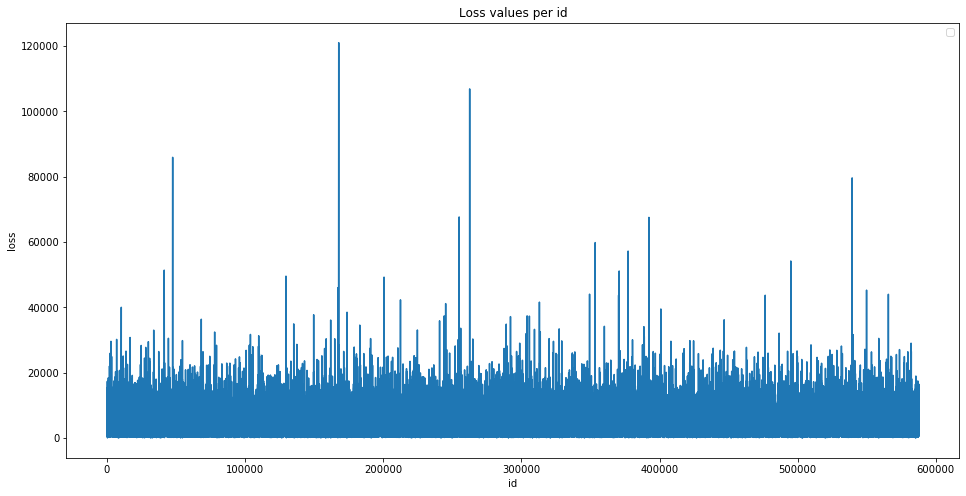

In [51]:
plt.figure(figsize=(16,8))
plt.plot(train['id'], train['loss'])
plt.title('Loss values per id')
plt.xlabel('id')
plt.ylabel('loss')
plt.legend()
plt.show();

There are several distinctive peaks in the loss values representing severe accidents. Such data distribution makes this feature very skewed and can result in suboptimal performance of the regressor.



Basically, skewness measures the asymmetry of the probability distribution of a real-valued random variable about its mean. Let's calculate the skewness of loss:



In [53]:
stats.mstats.skew(train['loss']).data


array(3.79492815)

Yes, the data is skewed. We can measure the skewness with stats.mstats.skew:

When we apply np.log to this vector, we get better results:

In [54]:
stats.mstats.skew(np.log(train['loss'])).data


array(0.0929738)

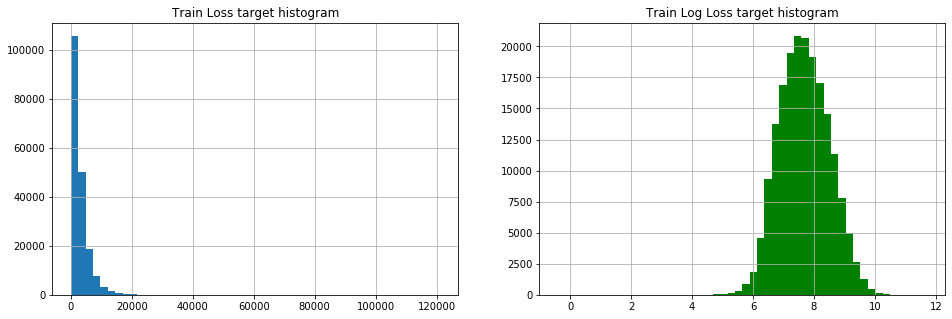

In [56]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax1.hist(train['loss'], bins=50)
ax1.set_title('Train Loss target histogram')
ax1.grid(True)
ax2.hist(np.log(train['loss']), bins=50, color='g')
ax2.set_title('Train Log Loss target histogram')
ax2.grid(True)
plt.show()

## Continuous features

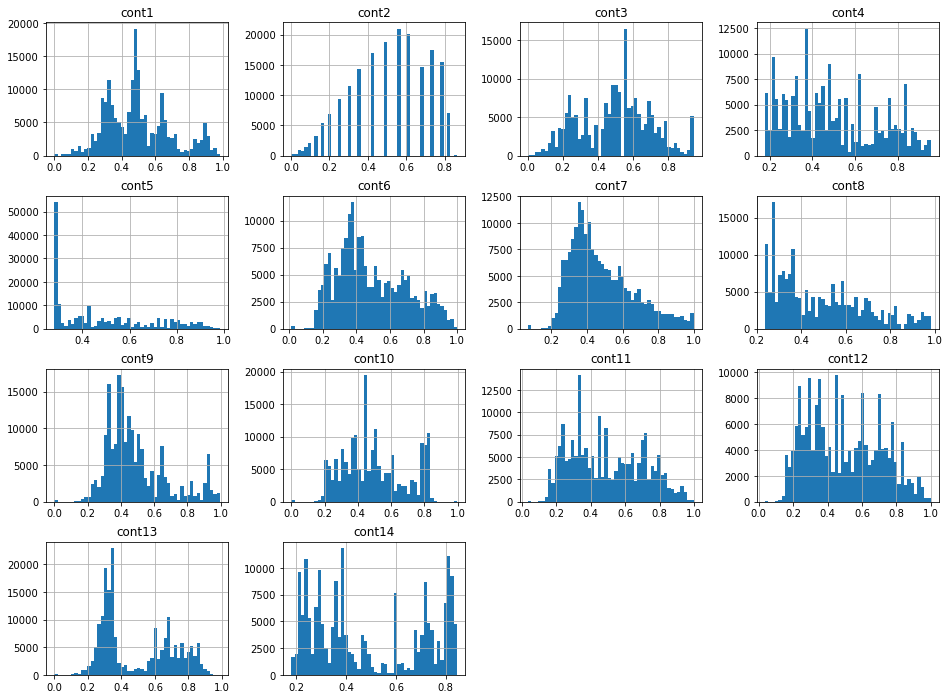

In [58]:
train[cont_features].hist(bins=50, figsize=(16,12));


## Feature Correlation (Pearson)¶

##  visualize correlations among all numerical features.

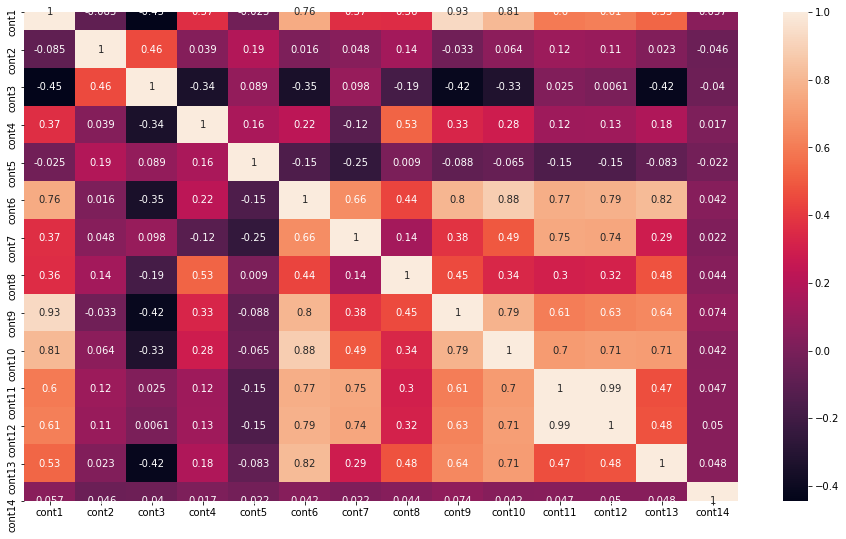

In [61]:
plt.subplots(figsize=(16,9))
correlation_mat = train[cont_features].corr()
sns.heatmap(correlation_mat, annot=True);

In [131]:
train.corr()['loss'].sort_values()

cont4      -0.035831
cont5      -0.011355
cont1      -0.010237
cont13     -0.004022
id         -0.001122
cont9       0.014456
cont14      0.019298
cont10      0.020236
cont8       0.030508
cont6       0.040967
cont12      0.098724
cont11      0.099806
cont3       0.111053
cont7       0.119799
cont2       0.141528
log_loss    0.857526
loss        1.000000
Name: loss, dtype: float64

We see a high correlation among several features. This may be a result of a data-based multicollinearity as two or more predictors are highly correlated. There are many problems it causes, so we should be very careful while implementing linear regression models on current dataset.



In [62]:
train.shape

(188318, 132)

## XGBoost -eXtreme Gradient Boosted Trees

XGBoost is an ensemble method 

Each tree boosts attributes that led to mis-classification of previous tree

It this amazing because it routinely wins Kaggle competitions

easy to use

fast 

a good choice for an algorithm to start with

Features of XGBoost

regularized boosting (prevent overfitting)

can handle missing values automatically

parallel processing 

can cross-validate at each iteration

incremental training

can plug in your own optimization objectives

tree pruning

In [ ]:
# Use DMatrix structure to hold features and labels 

In [67]:

import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, hstack
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [74]:
train=pd.read_csv("/users/arissa/Desktop/train.csv")
train['log_loss'] = np.log(train['loss'])


In [ ]:
ntrain = train.shape[0]

train_x = train[features]
train_y = train['log_loss']

# transfer categorical variables to numerical variables
for c in range(len(cat_features)):
    train_x[cat_features[c]] = train_x[cat_features[c]].astype('category').cat.codes
    
print("Xtrain:", train_x.shape)
print("ytrain:", train_y.shape)

In [76]:
features = [x for x in train.columns if x not in ['id','loss', 'log_loss']]

cat_features = [x for x in train.select_dtypes(
        include=['object']).columns if x not in ['id','loss', 'log_loss']]
num_features = [x for x in train.select_dtypes(
        exclude=['object']).columns if x not in ['id','loss', 'log_loss']]

print("Categorical features:", len(cat_features))
print("Numerical features:", len(num_features))

Categorical features: 116
Numerical features: 14


In [156]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


In [151]:
train_x

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,1,0,1,0,0,0,0,1,0,...,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,0,1,0,0,0,0,0,0,1,1,...,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,0,1,0,0,1,0,0,0,1,1,...,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,1,1,0,1,0,0,0,0,1,0,...,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,0,1,0,1,0,0,0,0,1,1,...,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,0,1,0,0,0,0,0,0,1,0,...,0.939556,0.242437,0.289949,0.24564,0.30859,0.32935,0.223038,0.220003,0.333292,0.208216
188314,0,0,0,0,0,1,0,0,0,0,...,0.704268,0.334270,0.382000,0.63475,0.40455,0.47779,0.307628,0.301921,0.318646,0.305872
188315,0,1,0,0,0,0,0,1,1,0,...,0.482436,0.345883,0.370534,0.24564,0.45808,0.47779,0.445614,0.443374,0.339244,0.503888
188316,0,1,0,0,0,0,0,0,1,1,...,0.340543,0.704364,0.562866,0.34987,0.44767,0.53881,0.863052,0.852865,0.654753,0.721707


In [153]:
train_y=train['loss']

In [157]:
X_train, X_test, y_train, y_test=train_test_split(train_x,train_y, test_size=0.3, random_state=42)

## Linear Regression


In [160]:
linear_model=LinearRegression()
linear_model.fit(X_train,y_train)
coef=linear_model.coef_
line_pre=linear_model.predict(X_test)
print('Score:{:.4f}'.format(linear_model.score(X_test, y_test)))
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(y_test, line_pre))))
print('MAE:{:.4f}'.format(np.sqrt(mean_absolute_error(y_test,line_pre))))


Score:0.4809
RMSE:2076.5137
MAE:36.4674


Linear Rregression model'Root Mean Squared Error is 2076.5137. 

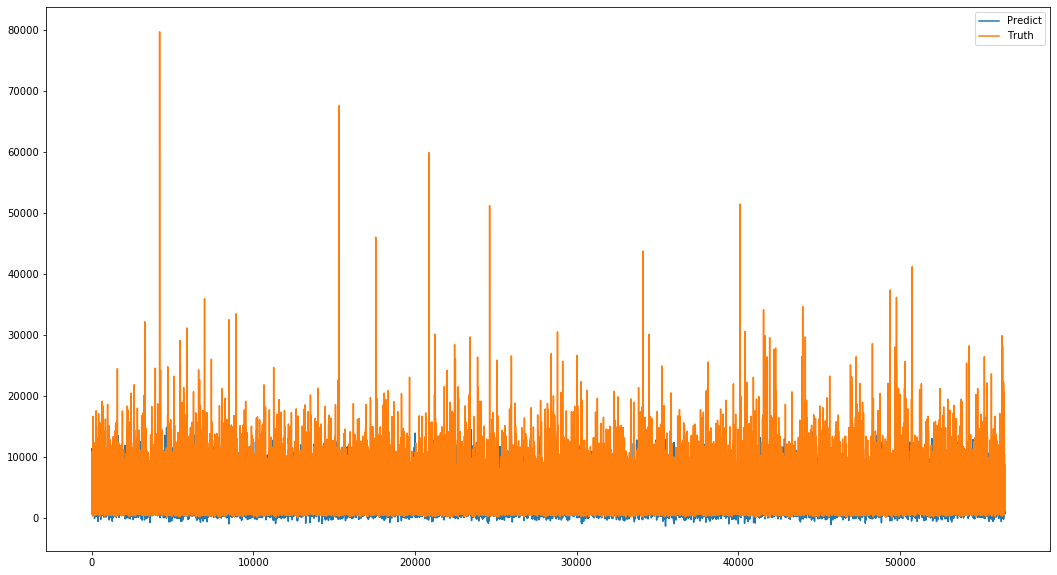

In [161]:
hos_pre = pd.DataFrame()
hos_pre['Predict'] = line_pre
hos_pre['Truth'] = y_test.reset_index(drop=True)
hos_pre.plot(figsize=(18,10));

We visualize the linear regression predicts, and we want to keep looking for a better model. 

## We want to try the result of log loss

In [163]:
train_log=train.drop(columns=['id','loss'])

In [164]:
train_log

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,log_loss
0,A,B,A,B,A,A,A,A,B,A,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,7.702186
1,A,B,A,A,A,A,A,A,B,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,7.157424
2,A,B,A,A,B,A,A,A,B,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,8.008063
3,B,B,A,B,A,A,A,A,B,A,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,6.845720
4,A,B,A,B,A,A,A,A,B,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,7.924380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,A,B,A,A,A,A,A,A,B,A,...,0.242437,0.289949,0.24564,0.30859,0.32935,0.223038,0.220003,0.333292,0.208216,7.088926
188314,A,A,A,A,A,B,A,A,A,A,...,0.334270,0.382000,0.63475,0.40455,0.47779,0.307628,0.301921,0.318646,0.305872,7.010619
188315,A,B,A,A,A,A,A,B,B,A,...,0.345883,0.370534,0.24564,0.45808,0.47779,0.445614,0.443374,0.339244,0.503888,8.659151
188316,A,B,A,A,A,A,A,A,B,B,...,0.704364,0.562866,0.34987,0.44767,0.53881,0.863052,0.852865,0.654753,0.721707,7.354279


In [166]:
from sklearn.preprocessing import LabelEncoder


In [174]:
for c in range(len(cat_features)):
    train_log[cat_features[c]] = train_log[cat_features[c]].astype('category').cat.codes

In [175]:
train_log

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,log_loss
0,0,1,0,1,0,0,0,0,1,0,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,7.702186
1,0,1,0,0,0,0,0,0,1,1,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,7.157424
2,0,1,0,0,1,0,0,0,1,1,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,8.008063
3,1,1,0,1,0,0,0,0,1,0,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,6.845720
4,0,1,0,1,0,0,0,0,1,1,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,7.924380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188313,0,1,0,0,0,0,0,0,1,0,...,0.242437,0.289949,0.24564,0.30859,0.32935,0.223038,0.220003,0.333292,0.208216,7.088926
188314,0,0,0,0,0,1,0,0,0,0,...,0.334270,0.382000,0.63475,0.40455,0.47779,0.307628,0.301921,0.318646,0.305872,7.010619
188315,0,1,0,0,0,0,0,1,1,0,...,0.345883,0.370534,0.24564,0.45808,0.47779,0.445614,0.443374,0.339244,0.503888,8.659151
188316,0,1,0,0,0,0,0,0,1,1,...,0.704364,0.562866,0.34987,0.44767,0.53881,0.863052,0.852865,0.654753,0.721707,7.354279


In [177]:
X_log=train_log.drop(columns='log_loss')
y_log=train_log['log_loss']

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X_log,y_log, test_size=0.3, random_state=18)

linear_model=LinearRegression()
linear_model.fit(X_train,y_train)
coef=linear_model.coef_
line_pre=linear_model.predict(X_test)
# transfer logged y_test to exponential
# prediction value is also transfered to exponential 
y_test=np.exp(y_test)
line_pre=np.exp(line_pre)
print('Score:{:.4f}'.format(linear_model.score(X_test, y_test)))
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(y_test, line_pre))))
print('MAE:{:.4f}'.format(np.sqrt(mean_absolute_error(y_test,line_pre))))

Score:-1.0910
RMSE:2268.5460
MAE:35.8424


 RMSE doesn't improve, and we can ignore the score because we exponential transfered our depedent variable

## Linear Suppor Vector Machine

In [196]:
from sklearn.svm import LinearSVR


In [194]:
X_train, X_test, y_train, y_test=train_test_split(train_x,train_y, test_size=0.3, random_state=42)

In [198]:
model = LinearSVR(epsilon=0.0, tol=0.0001, C=1.0, loss='epsilon_insensitive',fit_intercept=True, intercept_scaling=1.0, dual=True, verbose=0,
random_state=None, max_iter=1000)

model.fit(X_train, y_train)
predicted = model.predict(X_test)

In [199]:
print('Score:{:.4f}'.format(model.score(X_test, y_test)))
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(y_test, predicted))))
print('MAE:{:.4f}'.format(np.sqrt(mean_absolute_error(y_test,predicted))))

Score:0.4203
RMSE:2194.3857
MAE:35.7500


 The linear SVR result doesn't improve a lot. We will keep trying other algorithms.

## Gradient Boosting Regressor

In [200]:
from sklearn.ensemble import GradientBoostingRegressor as gbr


In [202]:
n_estimators= 100
reg2 = gbr(n_estimators=n_estimators,learning_rate=0.05)

In [203]:
reg2 = reg2.fit(X_train, y_train)


In [208]:
pred = np.exp(reg2.predict(X_test))
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(y_test, predicted))))
print('MAE:{:.4f}'.format(np.sqrt(mean_absolute_error(y_test,predicted))))

RMSE:2194.3857
MAE:35.7500


The RMSE is still very similar to previous models.

## Simple XGBoost Model


To start with, we train a baseline XGBoost model just to understand how well the whole training goes. As we aren't going to submit the results to Kaggle, we should cross validate them locally. Again, to make sure that an average PC can handle this, we now limit ourselves to 3-fold CV (we'll increase it to 5-fold CV later), 50 trees and stop if a CV error hasn't decreased in 10 rounds.

We use a custom evaluation function xg_eval_mae which calculates MAE, but works with our log-transformed data and uses XGBoost's DMatrix:

In [80]:
def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(y), np.exp(yhat))

## Model

We need to transform the initial dataset into the DMatrix, the native format of XGBoost.

DMatrix is an internal data structure that is used by XGBoost, which is optimized for both memory efficiency and training speed. You can construct DMatrix from multiple different sources of data.



In [84]:
dtrain = xgb.DMatrix(train_x, train['log_loss'])

## XGBoost Hyperparameters

Booster- gbtre or gblinear

Objective (ie, multi:softmax, multi:softprob)

Eta(learning rate-adjust weights on each step)

Max_depthn(depth of the tree)

Min_child_weight ( can control overfitting, but too high will underfit)
...


Now we run XGBoost and cross validate the results via the built-in xgb.cv function. We use our xg_eval_mae function for calculating the loss (MAE).



In [210]:
reg = xgb.XGBRegressor(n_estimators=1000,learning_rate=0.01)
reg.fit(X_train,y_train)
reg_predict = reg.predict(X_test)
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(reg_predict,y_test))))
print('MAE:{:.4f}'.format(np.sqrt(mean_absolute_error(reg_predict,y_test))))

RMSE:1889.0243
MAE:34.5205


In [ ]:
## RMSE decreased to 1889. XGBoost is a very powerful algorithm.

In [211]:
reg = xgb.XGBRegressor(n_estimators=2000,learning_rate=0.01)
reg.fit(X_train,y_train)
reg_predict = reg.predict(X_test)
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(reg_predict,y_test))))
print('MAE:{:.4f}'.format(np.sqrt(mean_absolute_error(reg_predict,y_test))))

RMSE:1879.8572
MAE:34.3888


## Hyperparameter Tuning 

In [214]:
from sklearn.model_selection import GridSearchCV


In [ ]:
# write a function to apply GridSearch, and to see which are the best params.
# This needs a long time to operate. 

In [215]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10,50],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [1000, 2000, 5000],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_


In [ ]:
hyperParameterTuning(X_train, y_train)

In [219]:
reg = xgb.XGBRegressor(n_estimators=5000,learning_rate=0.01)
reg.fit(X_train,y_train)
reg_predict = reg.predict(X_test)
print('RMSE:{:.4f}'.format(np.sqrt(mean_squared_error(reg_predict,y_test))))
print('MAE:{:.4f}'.format(np.sqrt(mean_absolute_error(reg_predict,y_test))))

RMSE:1880.4635
MAE:34.3440


XGBoost is the model has the lowest root mean squared error (RMSE). The running time of GridSearchCV will be very long. 
We expect to test more hyperparameters in order to reduce RMSE. At this stage, 1880.46 is our final result. 